In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import utils as u
import importlib
importlib.reload(u)
import pandas as pd
from collections import Counter

In [3]:
reconstructed_orbit = pd.read_parquet("../fink_fat_experiments/confirmed_all_fink_fat/mpc/orbital.parquet")
reconstructed_trajectory = pd.read_parquet("../fink_fat_experiments/confirmed_all_fink_fat/mpc/trajectory_orb.parquet")
input_data = pd.read_parquet("../fink_fat_experiments/confirmed_all_fink_fat/mpc/save/")

In [4]:
# Confirmed SSO in Input
len(input_data["ssnamenr"].unique())

86349

In [5]:
import numpy as np
is_detectable = input_data.sort_values("jd").groupby("ssnamenr").agg(
    nb_det=("ra", len),
    is_in_tw=("jd", lambda x: np.all(np.diff(x)<=15))
)

In [6]:
# Detectable
len(is_detectable[(is_detectable["nb_det"] >= 6) & (is_detectable["is_in_tw"])])

43488

In [7]:
# Reconstructed
len(reconstructed_orbit)

37019

In [8]:
# With error (rms)
orbit_with_error = reconstructed_orbit[reconstructed_orbit["rms_a"] != -1.0]
traj_with_error = reconstructed_trajectory[reconstructed_trajectory["ssoCandId"].isin(orbit_with_error["ssoCandId"])]
len(orbit_with_error)

11963

In [9]:
count_ssnamenr = reconstructed_trajectory[["ssoCandId", "ssnamenr"]].groupby("ssoCandId").agg(
    ssnamenr=("ssnamenr", list),
    count_ssnamenr=("ssnamenr", lambda x: len(Counter(x)))
)

count_ssnamenr_with_error = traj_with_error[["ssoCandId", "ssnamenr"]].groupby("ssoCandId").agg(
    ssnamenr=("ssnamenr", list),
    count_ssnamenr=("ssnamenr", lambda x: len(Counter(x)))
)

pure_orbit_with_error = reconstructed_orbit[reconstructed_orbit["ssoCandId"].isin(count_ssnamenr_with_error[count_ssnamenr_with_error["count_ssnamenr"] == 1].reset_index()["ssoCandId"])]

# Pure
len(count_ssnamenr[count_ssnamenr["count_ssnamenr"] == 1]), len(count_ssnamenr_with_error[count_ssnamenr_with_error["count_ssnamenr"] == 1])

(23903, 11456)

In [10]:
# Unique
len(count_ssnamenr[count_ssnamenr["count_ssnamenr"] == 1].explode("ssnamenr").drop_duplicates("ssnamenr")), len(count_ssnamenr_with_error[count_ssnamenr_with_error["count_ssnamenr"] == 1].explode("ssnamenr").drop_duplicates("ssnamenr"))

(18379, 10199)

In [11]:
# Purity
((len(count_ssnamenr[count_ssnamenr["count_ssnamenr"] == 1]) / len(reconstructed_orbit)) * 100), ((len(count_ssnamenr_with_error[count_ssnamenr_with_error["count_ssnamenr"] == 1]) / len(orbit_with_error)) * 100)

(64.5695453685945, 95.76193262559559)

## Results

|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Confirmed SSO input | 86349    | X               |
| Detectable          | 43488    | X               |
| Reconstructed orbit | 37019    | 11963           |
| - Pure              | 23903    | 11456           |
| - Unique            | 18379    | 10199           |
| Purity              | 64.6 %   | 95.8 %          |
| Efficiency          | 42.3 %   | 23.4 %          |

### Number of detection

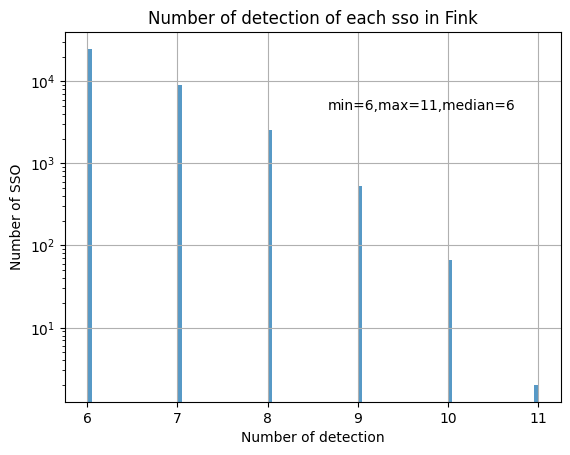

In [12]:
u.plot_nb_det_distribution(reconstructed_trajectory)

### Observation window

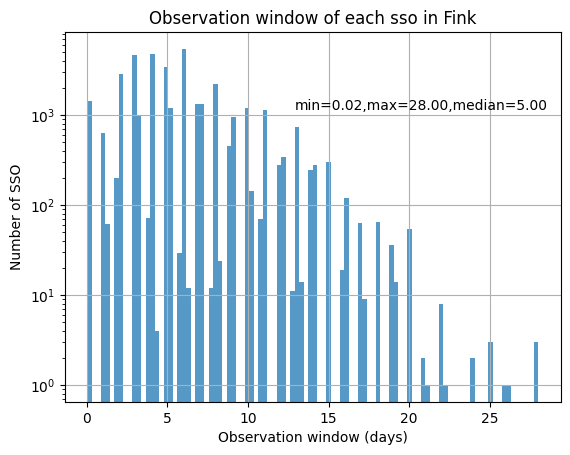

In [13]:
u.plot_tw_distribution(reconstructed_trajectory)

### Orbfit RMS distribution

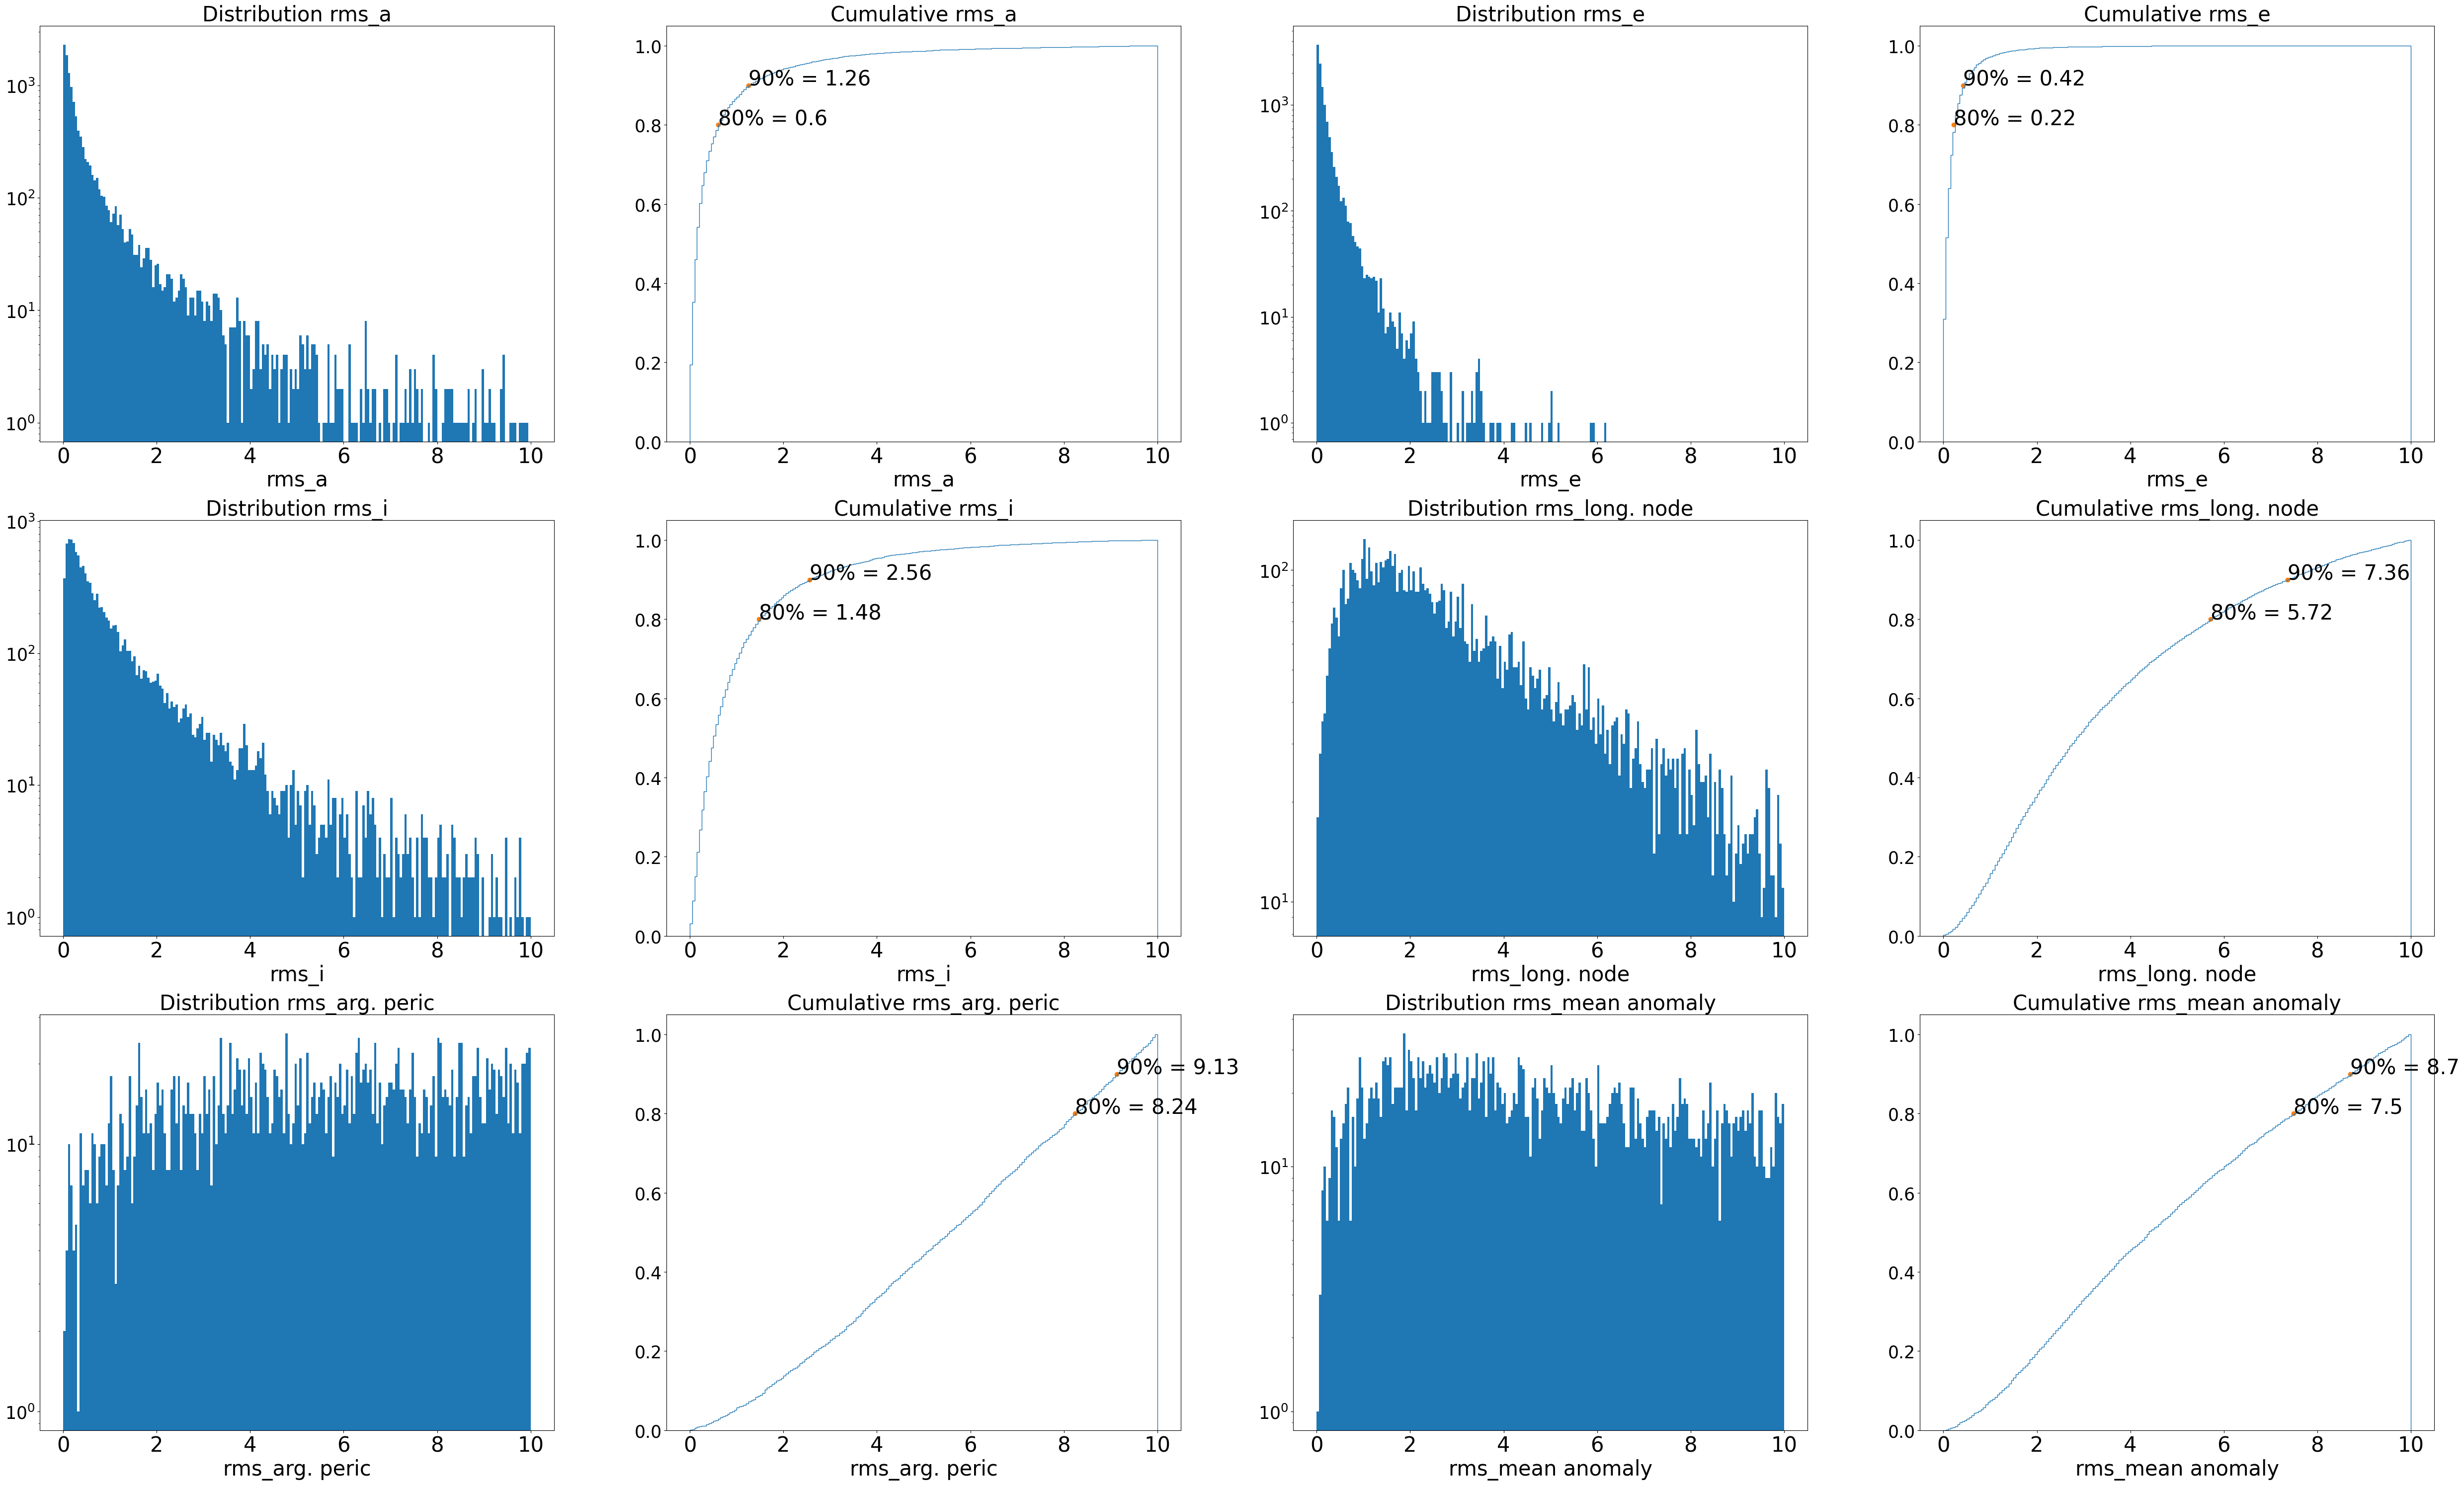

In [14]:
u.plot_hist_and_cdf(
    orbit_with_error, [0, 10]
)

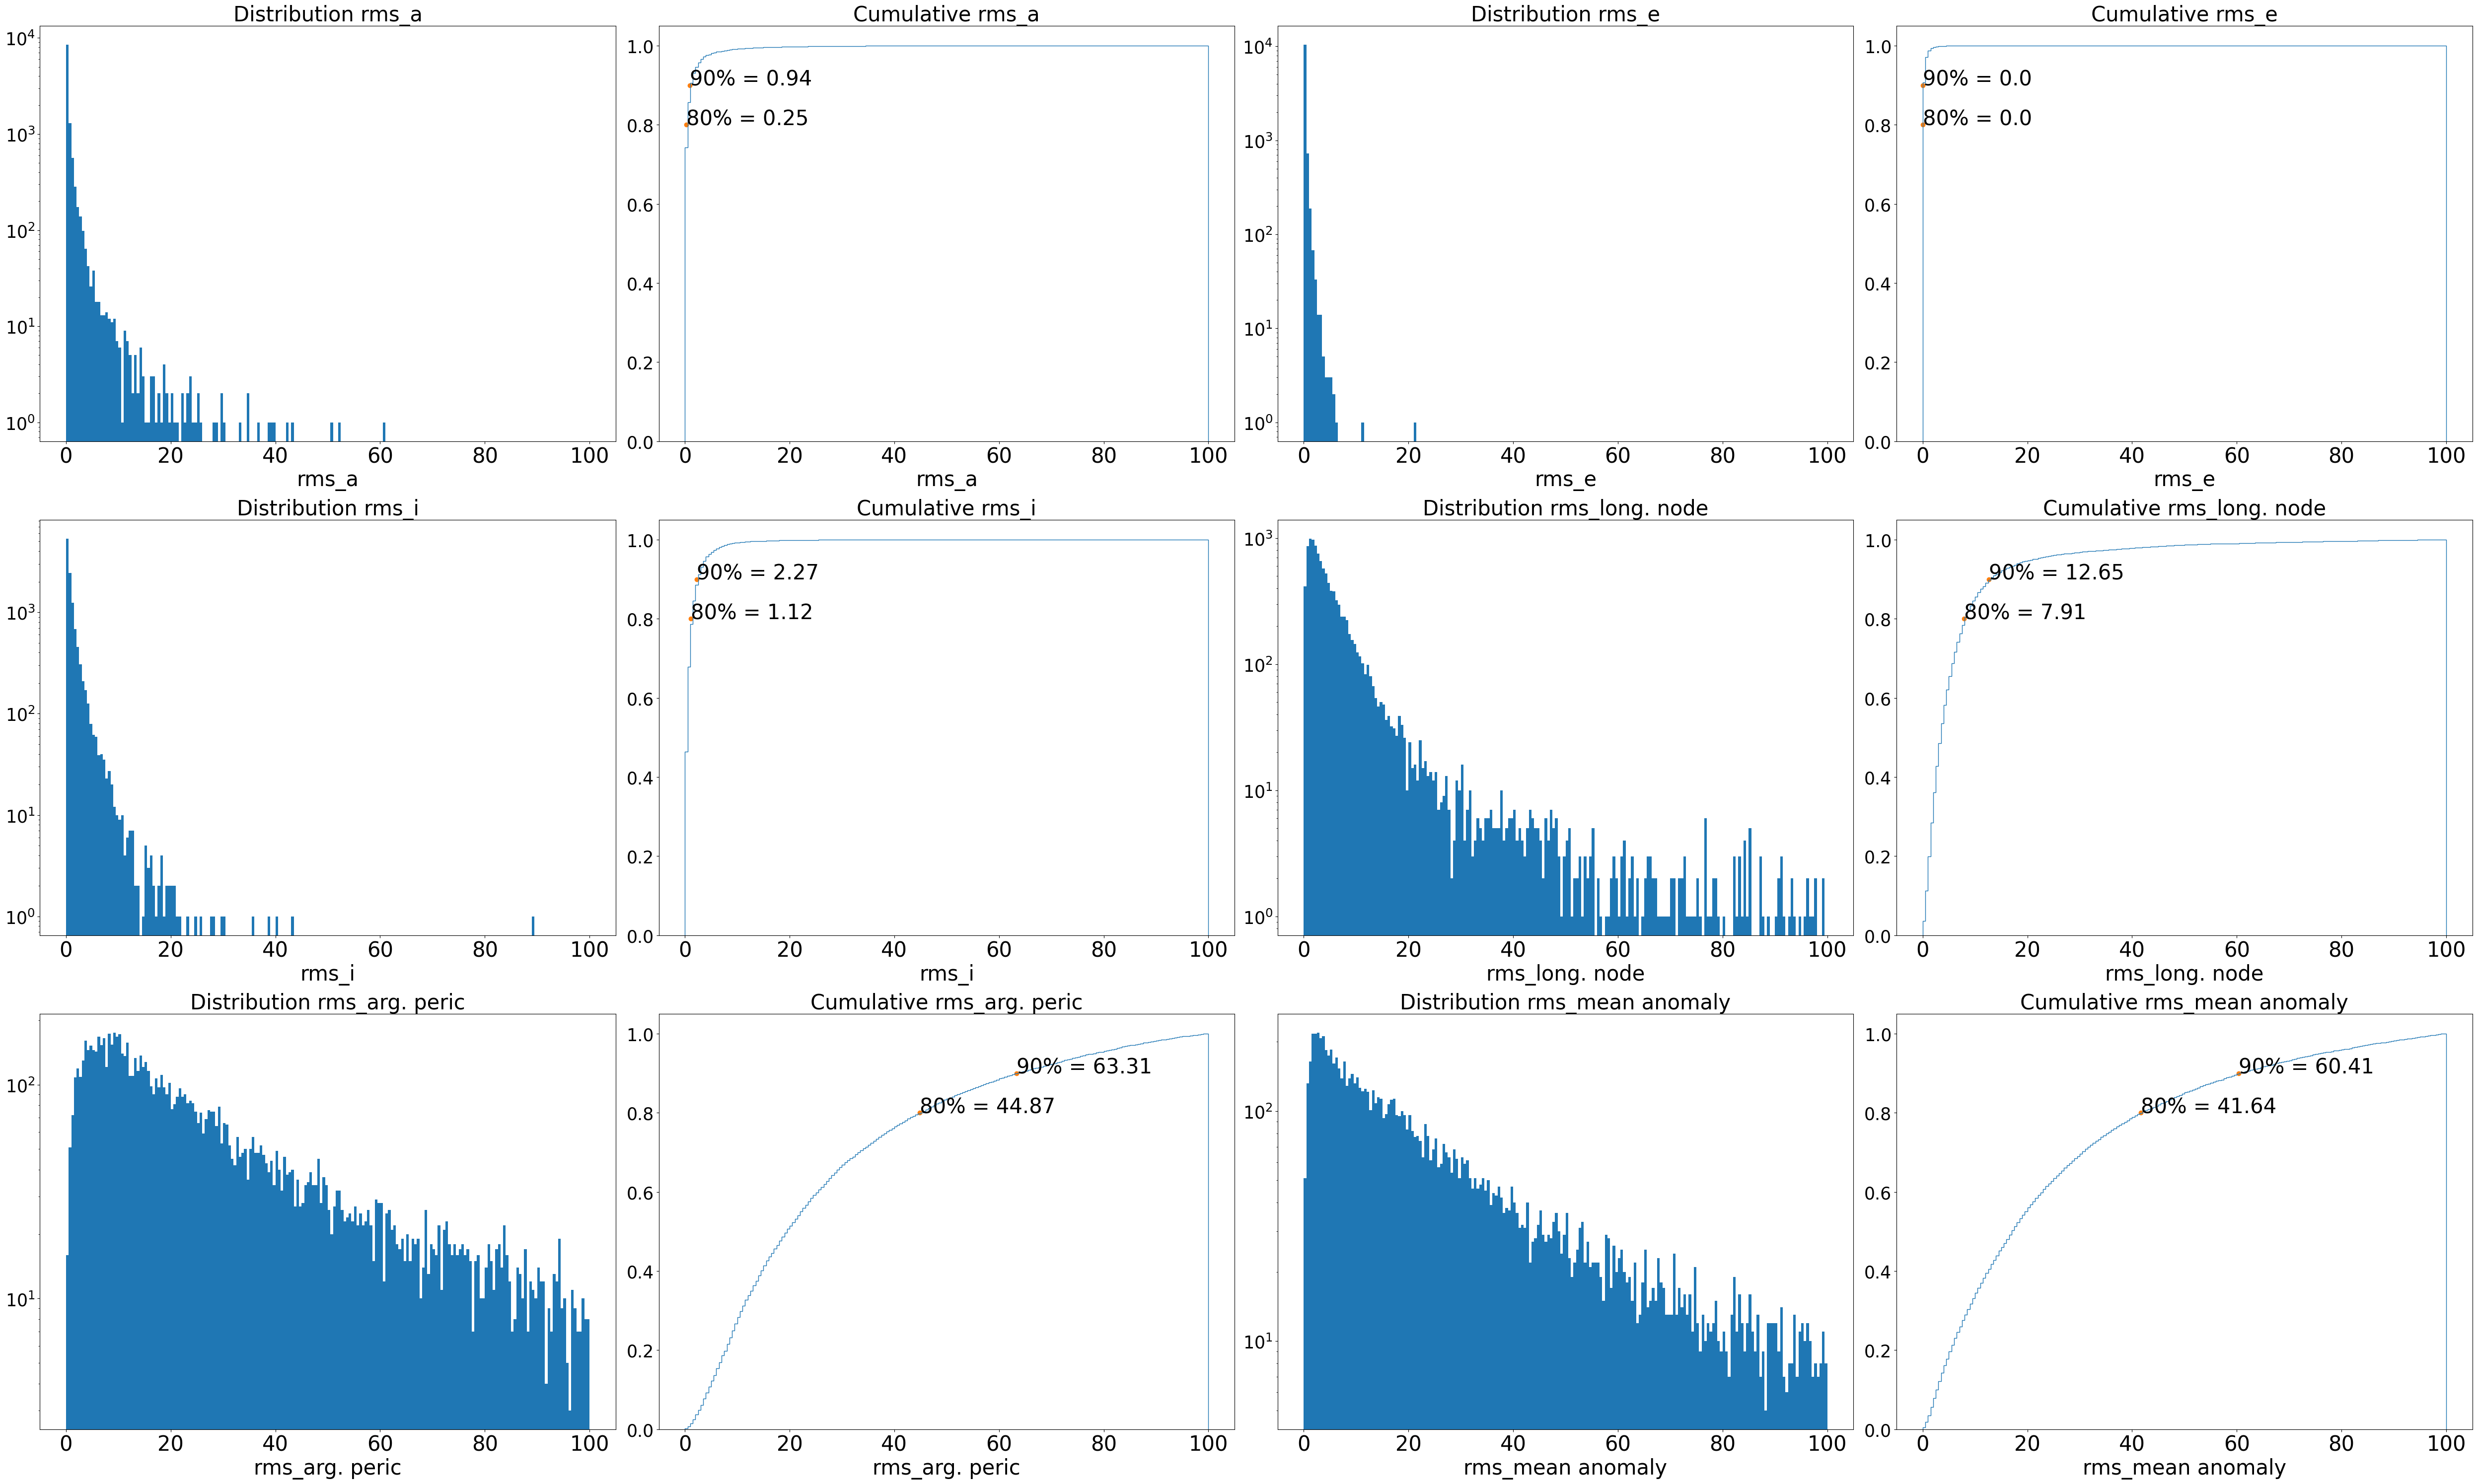

In [15]:
u.plot_hist_and_cdf(
    pure_orbit_with_error, [0, 100]
)

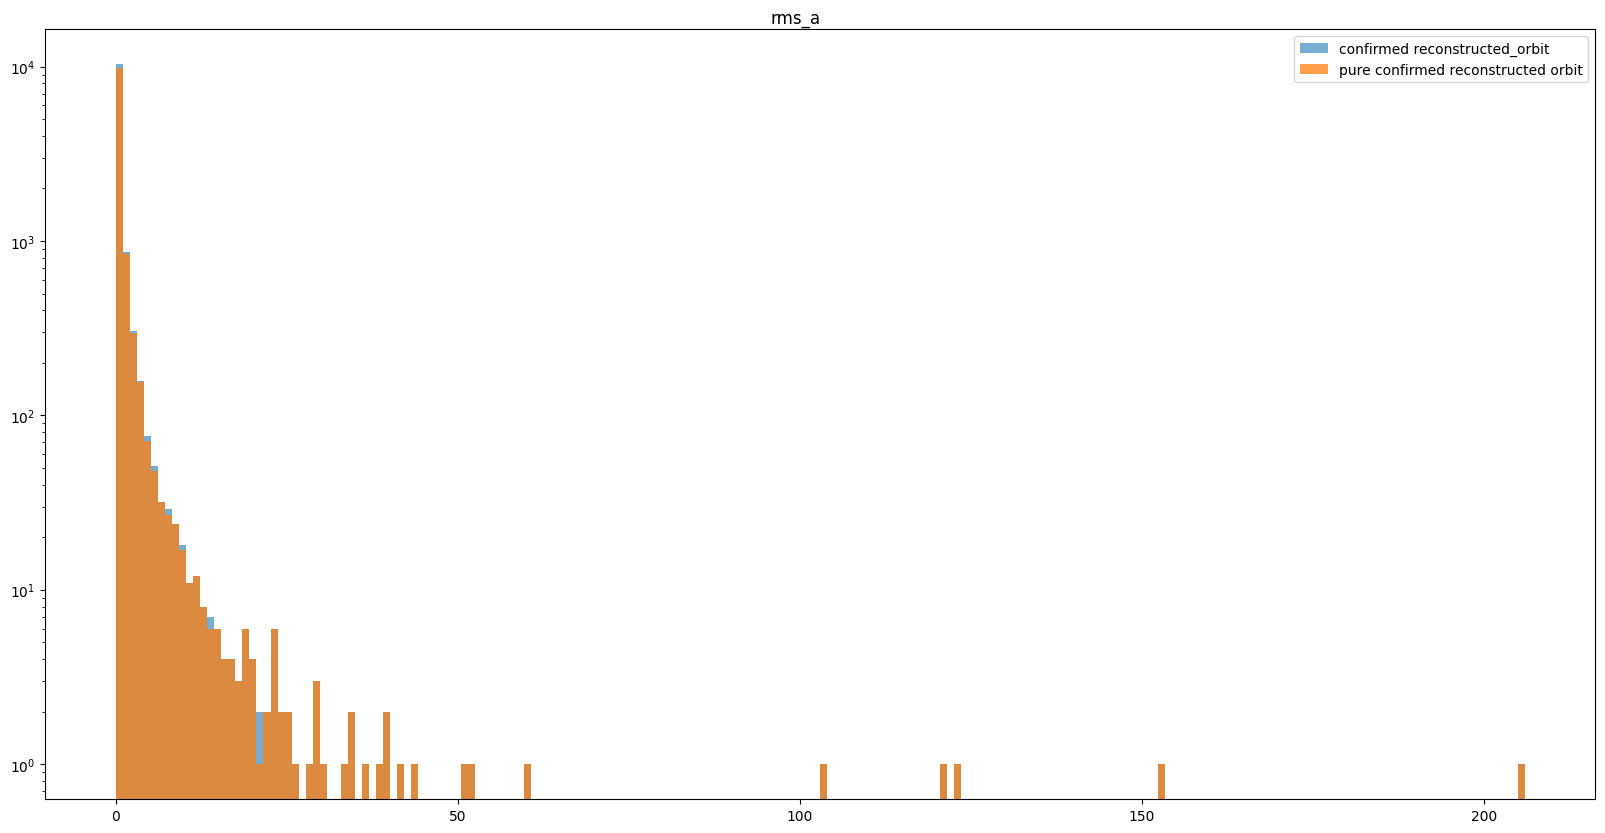

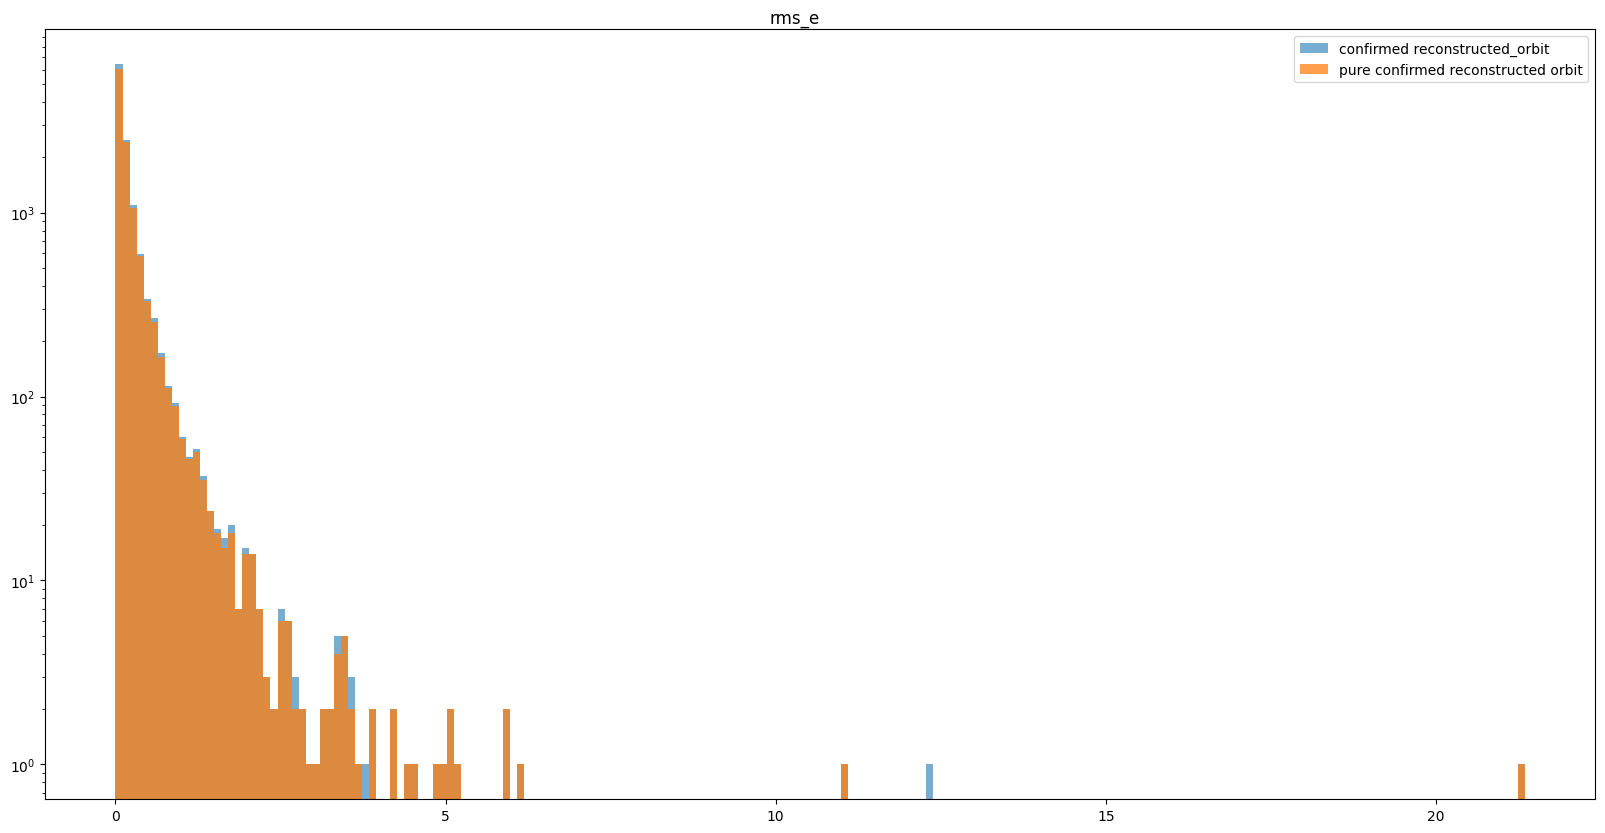

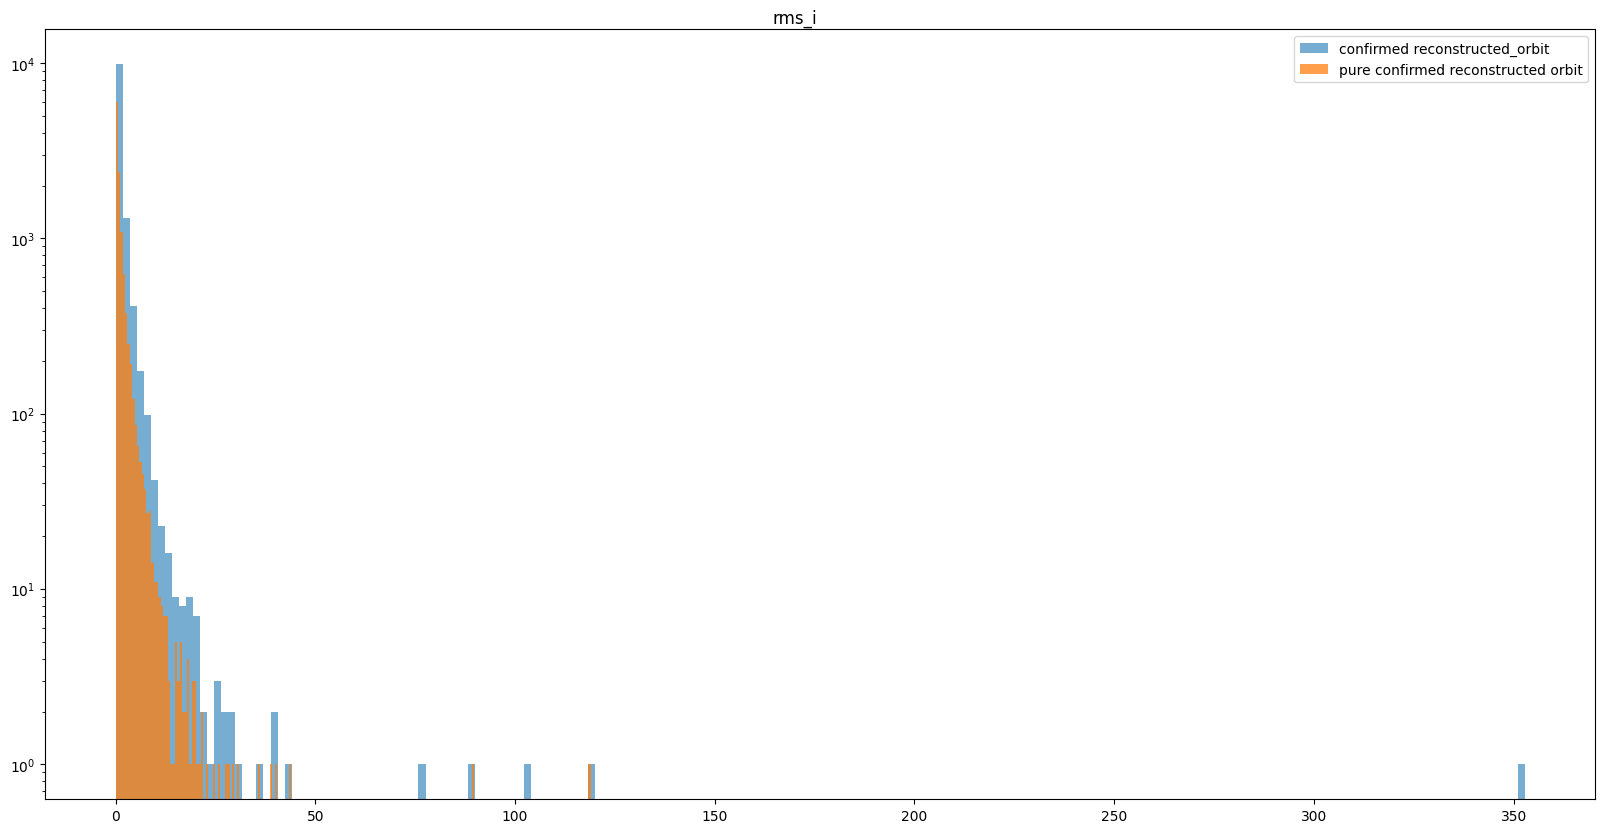

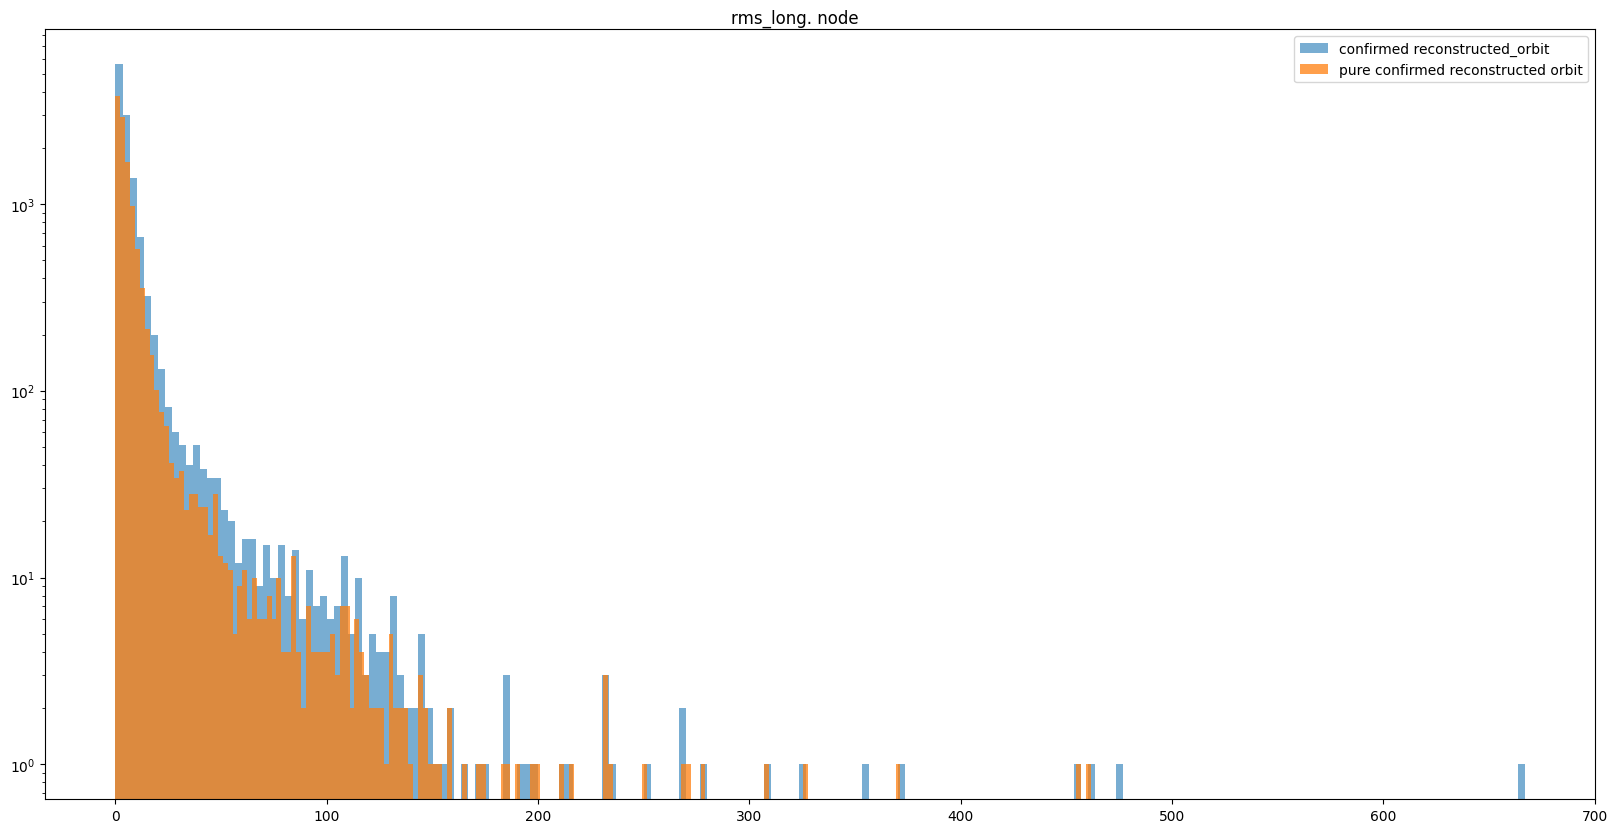

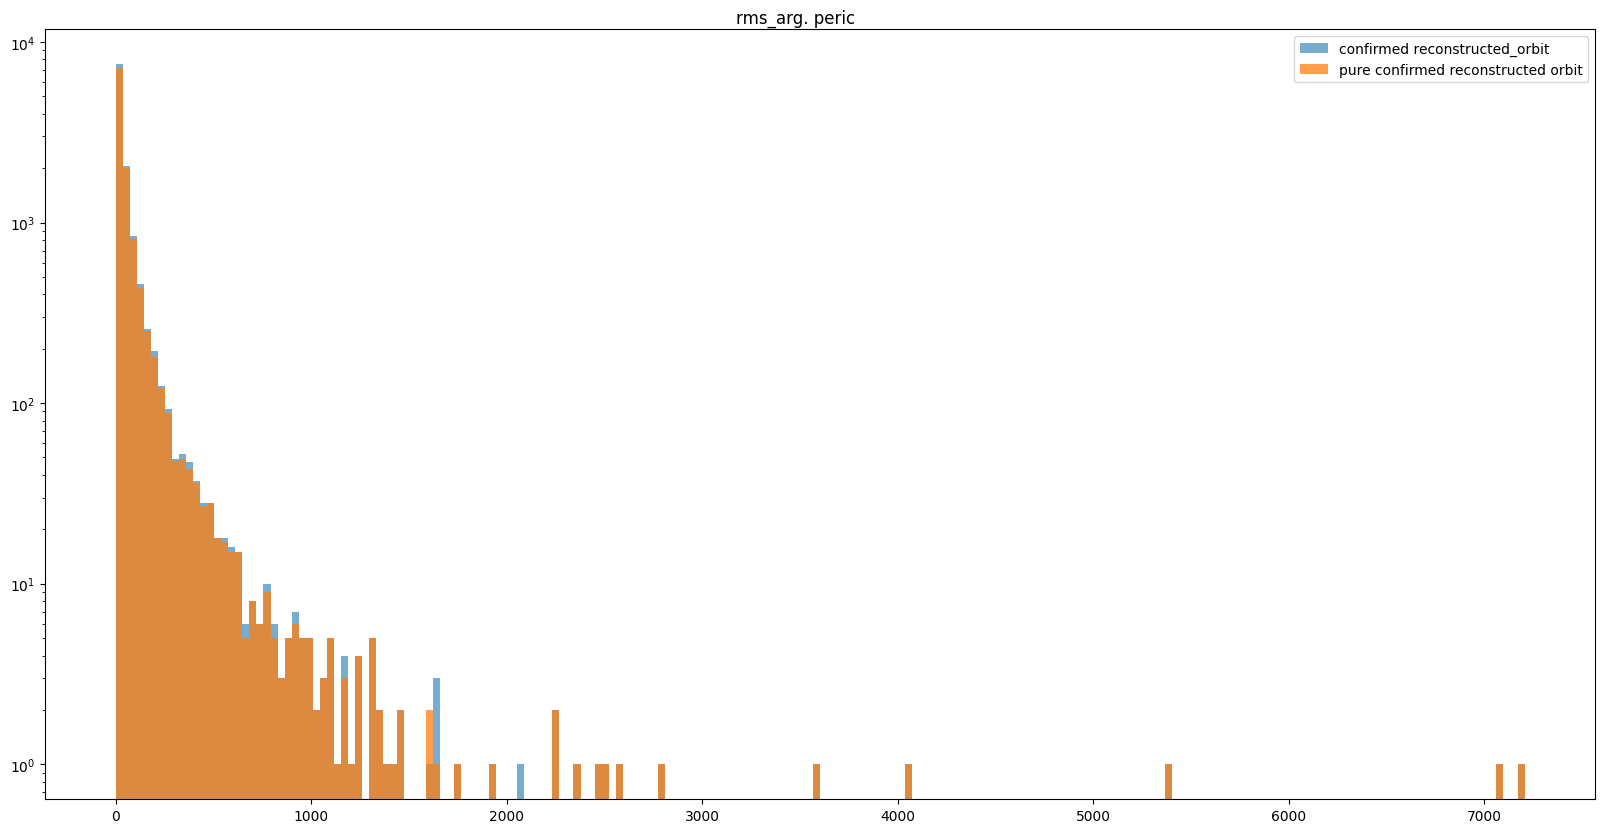

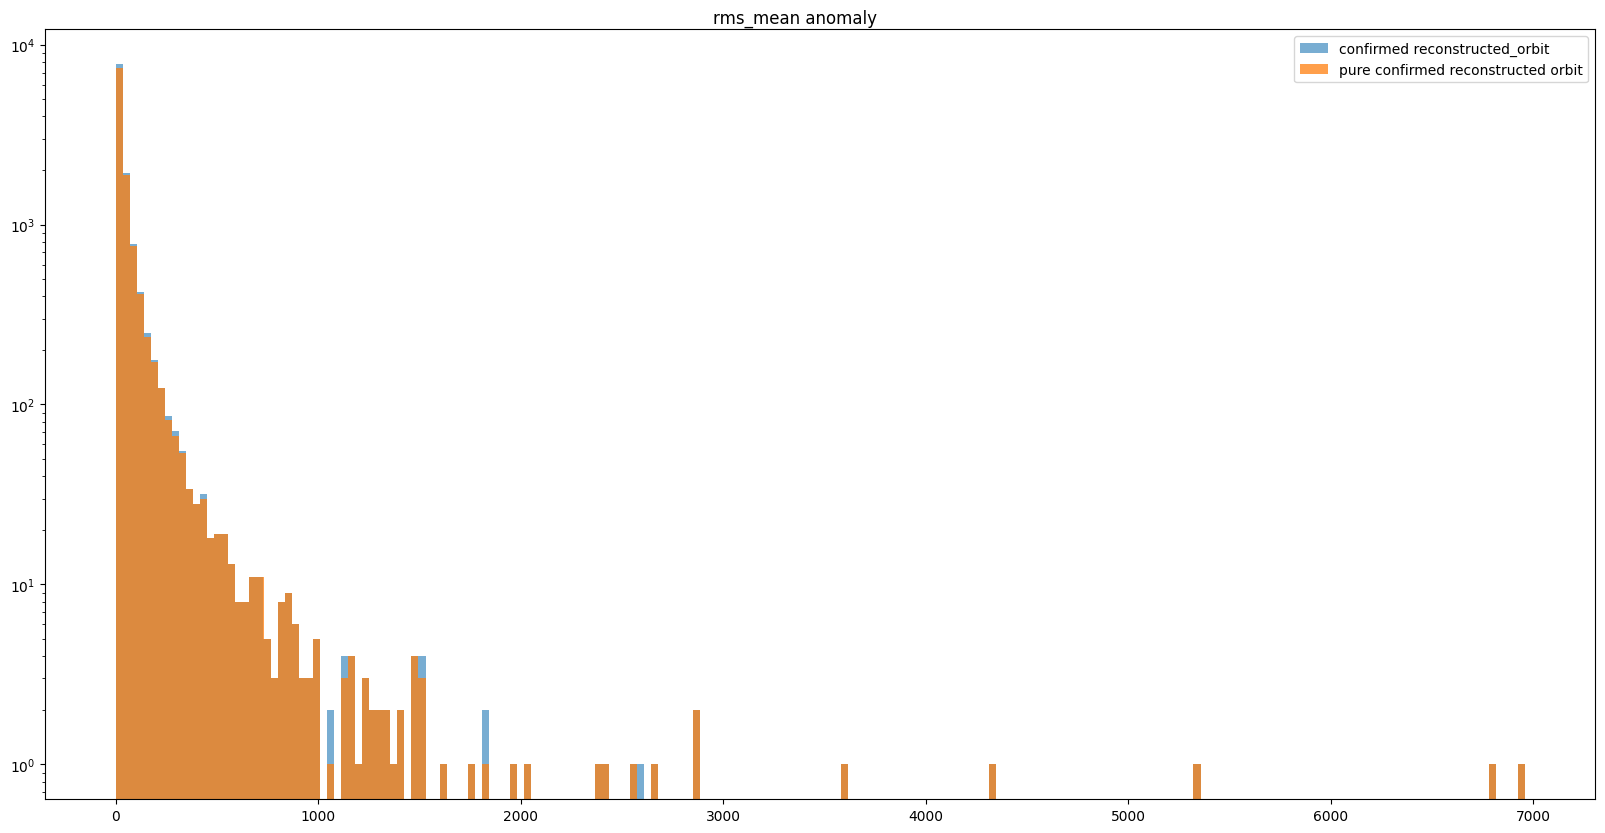

In [17]:
import matplotlib.pyplot as plt

for rms in ['rms_a', 'rms_e', 'rms_i', 'rms_long. node', 'rms_arg. peric', 'rms_mean anomaly']:
    fig = plt.figure(figsize=(20, 10))
    plt.hist(orbit_with_error[rms], bins=200, log=True, alpha=0.6, label="confirmed reconstructed_orbit")
    fig.suptitle(rms, y=0.9)
    plt.hist(pure_orbit_with_error[rms], bins=200, log=True, alpha=0.75, label="pure confirmed reconstructed orbit")
    plt.legend()
    plt.show()